<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html chapter13.do.txt  -->

# Recurrent neural networks: Overarching view

Till now our focus has been, including convolutional neural networks
as well, on feedforward neural networks. The output or the activations
flow only in one direction, from the input layer to the output layer.

A recurrent neural network (RNN) looks very much like a feedforward
neural network, except that it also has connections pointing
backward. 

RNNs are used to analyze time series data such as stock prices, and
tell you when to buy or sell. In autonomous driving systems, they can
anticipate car trajectories and help avoid accidents. More generally,
they can work on sequences of arbitrary lengths, rather than on
fixed-sized inputs like all the nets we have discussed so far. For
example, they can take sentences, documents, or audio samples as
input, making them extremely useful for natural language processing
systems such as automatic translation and speech-to-text.

More to text to be added

## A simple example

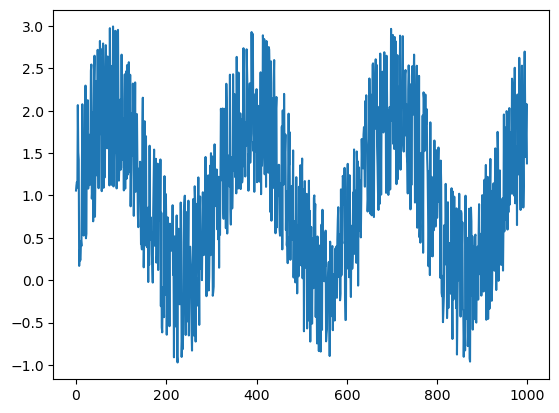

Metal device set to: Apple M1


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 simple_rnn (SimpleRNN)      (None, 32)                1184      


 dense (Dense)               (None, 8)                 264       


 dense_1 (Dense)             (None, 1)                 9         


Total params: 1,457


Trainable params: 1,457


Non-trainable params: 0


_________________________________________________________________


Epoch 1/100


2023-11-21 06:09:51.383315: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


50/50 - 2s - loss: 0.6262 - 2s/epoch - 43ms/step


Epoch 2/100


50/50 - 0s - loss: 0.4148 - 440ms/epoch - 9ms/step


Epoch 3/100


50/50 - 0s - loss: 0.4134 - 485ms/epoch - 10ms/step


Epoch 4/100


50/50 - 1s - loss: 0.4111 - 507ms/epoch - 10ms/step


Epoch 5/100


50/50 - 0s - loss: 0.4099 - 446ms/epoch - 9ms/step


Epoch 6/100


50/50 - 0s - loss: 0.4051 - 449ms/epoch - 9ms/step


Epoch 7/100


50/50 - 0s - loss: 0.4082 - 448ms/epoch - 9ms/step


Epoch 8/100


50/50 - 0s - loss: 0.4052 - 447ms/epoch - 9ms/step


Epoch 9/100


50/50 - 0s - loss: 0.4032 - 446ms/epoch - 9ms/step


Epoch 10/100


50/50 - 0s - loss: 0.4053 - 439ms/epoch - 9ms/step


Epoch 11/100


50/50 - 0s - loss: 0.4007 - 446ms/epoch - 9ms/step


Epoch 12/100


50/50 - 0s - loss: 0.4036 - 446ms/epoch - 9ms/step


Epoch 13/100


50/50 - 0s - loss: 0.4008 - 449ms/epoch - 9ms/step


Epoch 14/100


50/50 - 0s - loss: 0.3978 - 447ms/epoch - 9ms/step


Epoch 15/100


50/50 - 0s - loss: 0.4018 - 449ms/epoch - 9ms/step


Epoch 16/100


50/50 - 0s - loss: 0.3984 - 448ms/epoch - 9ms/step


Epoch 17/100


50/50 - 0s - loss: 0.3975 - 446ms/epoch - 9ms/step


Epoch 18/100


50/50 - 0s - loss: 0.3954 - 447ms/epoch - 9ms/step


Epoch 19/100


50/50 - 0s - loss: 0.3995 - 446ms/epoch - 9ms/step


Epoch 20/100


50/50 - 0s - loss: 0.3987 - 449ms/epoch - 9ms/step


Epoch 21/100


50/50 - 0s - loss: 0.3961 - 446ms/epoch - 9ms/step


Epoch 22/100


50/50 - 0s - loss: 0.3948 - 444ms/epoch - 9ms/step


Epoch 23/100


50/50 - 0s - loss: 0.3968 - 447ms/epoch - 9ms/step


Epoch 24/100


50/50 - 0s - loss: 0.3970 - 447ms/epoch - 9ms/step


Epoch 25/100


50/50 - 0s - loss: 0.3929 - 444ms/epoch - 9ms/step


Epoch 26/100


50/50 - 0s - loss: 0.3971 - 445ms/epoch - 9ms/step


Epoch 27/100


50/50 - 0s - loss: 0.3960 - 446ms/epoch - 9ms/step


Epoch 28/100


50/50 - 0s - loss: 0.3915 - 447ms/epoch - 9ms/step


Epoch 29/100


50/50 - 0s - loss: 0.3942 - 449ms/epoch - 9ms/step


Epoch 30/100


50/50 - 0s - loss: 0.3937 - 445ms/epoch - 9ms/step


Epoch 31/100


50/50 - 0s - loss: 0.3944 - 445ms/epoch - 9ms/step


Epoch 32/100


50/50 - 0s - loss: 0.3912 - 446ms/epoch - 9ms/step


Epoch 33/100


50/50 - 0s - loss: 0.3939 - 445ms/epoch - 9ms/step


Epoch 34/100


50/50 - 0s - loss: 0.3932 - 446ms/epoch - 9ms/step


Epoch 35/100


50/50 - 0s - loss: 0.3863 - 445ms/epoch - 9ms/step


Epoch 36/100


50/50 - 0s - loss: 0.3880 - 446ms/epoch - 9ms/step


Epoch 37/100


50/50 - 0s - loss: 0.3888 - 447ms/epoch - 9ms/step


Epoch 38/100


50/50 - 0s - loss: 0.3893 - 446ms/epoch - 9ms/step


Epoch 39/100


50/50 - 0s - loss: 0.3895 - 446ms/epoch - 9ms/step


Epoch 40/100


50/50 - 0s - loss: 0.3904 - 448ms/epoch - 9ms/step


Epoch 41/100


50/50 - 0s - loss: 0.3877 - 448ms/epoch - 9ms/step


Epoch 42/100


50/50 - 0s - loss: 0.3852 - 446ms/epoch - 9ms/step


Epoch 43/100


50/50 - 0s - loss: 0.3902 - 446ms/epoch - 9ms/step


Epoch 44/100


50/50 - 0s - loss: 0.3856 - 446ms/epoch - 9ms/step


Epoch 45/100


50/50 - 0s - loss: 0.3876 - 447ms/epoch - 9ms/step


Epoch 46/100


50/50 - 0s - loss: 0.3880 - 444ms/epoch - 9ms/step


Epoch 47/100


50/50 - 0s - loss: 0.3873 - 446ms/epoch - 9ms/step


Epoch 48/100


50/50 - 0s - loss: 0.3848 - 448ms/epoch - 9ms/step


Epoch 49/100


50/50 - 0s - loss: 0.3852 - 447ms/epoch - 9ms/step


Epoch 50/100


50/50 - 0s - loss: 0.3877 - 447ms/epoch - 9ms/step


Epoch 51/100


50/50 - 0s - loss: 0.3852 - 447ms/epoch - 9ms/step


Epoch 52/100


50/50 - 0s - loss: 0.3840 - 446ms/epoch - 9ms/step


Epoch 53/100


50/50 - 0s - loss: 0.3834 - 444ms/epoch - 9ms/step


Epoch 54/100


50/50 - 0s - loss: 0.3851 - 446ms/epoch - 9ms/step


Epoch 55/100


50/50 - 0s - loss: 0.3864 - 446ms/epoch - 9ms/step


Epoch 56/100


50/50 - 0s - loss: 0.3812 - 447ms/epoch - 9ms/step


Epoch 57/100


KeyboardInterrupt: 

In [1]:
%matplotlib inline

# Start importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras import optimizers     
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical 



# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

plt.plot(df)
plt.show()

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

## An extrapolation example

The following code provides an example of how recurrent neural
networks can be used to extrapolate to unknown values of physics data
sets.  Specifically, the data sets used in this program come from
a quantum mechanical many-body calculation of energies as functions of the number of particles.

In [2]:

# For matrices and calculations
import numpy as np
# For machine learning (backend for keras)
import tensorflow as tf
# User-friendly machine learning library
# Front end for TensorFlow
import tensorflow.keras
# Different methods from Keras needed to create an RNN
# This is not necessary but it shortened function calls 
# that need to be used in the code.
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
# For timing the code
from timeit import default_timer as timer
# For plotting
import matplotlib.pyplot as plt


# The data set
datatype='VaryDimension'
X_tot = np.arange(2, 42, 2)
y_tot = np.array([-0.03077640549, -0.08336233266, -0.1446729567, -0.2116753732, -0.2830637392, -0.3581341341, -0.436462435, -0.5177783846,
	-0.6019067271, -0.6887363571, -0.7782028952, -0.8702784034, -0.9649652536, -1.062292565, -1.16231451, 
	-1.265109911, -1.370782966, -1.479465113, -1.591317992, -1.70653767])

The way the recurrent neural networks are trained in this program
differs from how machine learning algorithms are usually trained.
Typically a machine learning algorithm is trained by learning the
relationship between the x data and the y data.  In this program, the
recurrent neural network will be trained to recognize the relationship
in a sequence of y values.  This is type of data formatting is
typically used time series forcasting, but it can also be used in any
extrapolation (time series forecasting is just a specific type of
extrapolation along the time axis).  This method of data formatting
does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the
form of (x,y) so the machine learning algorithm learns to assiciate a
y value with a given x value.  This is useful when the test data has x
values within the same range as the training data.  However, for this
application, the x values of the test data are outside of the x values
of the training data and the traditional method of training a machine
learning algorithm does not work as well.  For this reason, the
recurrent neural network is trained on sequences of y values of the
form ((y1, y2), y3), so that the network is concerned with learning
the pattern of the y data and not the relation between the x and y
data.  As long as the pattern of y data outside of the training region
stays relatively stable compared to what was inside the training
region, this method of training can produce accurate extrapolations to
y values far removed from the training data set.

In [3]:
# FORMAT_DATA
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output


# ## Defining the Recurrent Neural Network Using Keras
# 
# The following method defines a simple recurrent neural network in keras consisting of one input layer, one hidden layer, and one output layer.

def rnn(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 200
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

## Predicting New Points With A Trained Recurrent Neural Network

In [4]:
def test_rnn (x1, y_test, plot_min, plot_max):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y_test (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    y_pred = y_test[:dim].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[[y_test[dim-2]], [y_test[dim-1]]]])
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[dim-1]]

    # Iterate until the complete data set is created.
    for i in range (dim, len(y_test)):
        # Predict the next point in the data set using the previous two points.
        next = model.predict(next_input)
        # Append just the number of the predicted data set
        y_pred.append(next[0][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next

    # Print the mean squared error between the known data set and the predicted data set.
    print('MSE: ', np.square(np.subtract(y_test, y_pred)).mean())
    # Save the predicted data set as a csv file for later use
    name = datatype + 'Predicted'+str(dim)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.
    fig, ax = plt.subplots()
    ax.plot(x1, y_test, label="true", linewidth=3)
    ax.plot(x1, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Created a red region to represent the points used in the training data.
    ax.axvspan(plot_min, plot_max, alpha=0.25, color='red')
    plt.show()

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn(length_of_sequences = rnn_input.shape[1])
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

Changing the size of the recurrent neural network and its parameters
can drastically change the results you get from the model.  The below
code takes the simple recurrent neural network from above and adds a
second hidden layer, changes the number of neurons in the hidden
layer, and explicitly declares the activation function of the hidden
layers to be a sigmoid function.  The loss function and optimizer can
also be changed but are kept the same as the above network.  These
parameters can be tuned to provide the optimal result from the
network.  For some ideas on how to improve the performance of a
[recurrent neural network](https://danijar.com/tips-for-training-recurrent-neural-networks).

In [5]:
def rnn_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two hidden layers and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer, increased from the first network
    hidden_neurons = 500
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Create two hidden layers instead of one hidden layer.  Explicitly set the activation
    # function to be the sigmoid function (the default value is hyperbolic tangent)
    rnn1 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,  # This needs to be True if another hidden layer is to follow
                    stateful = stateful, activation = 'sigmoid',
                    name="RNN1")(inp)
    rnn2 = SimpleRNN(hidden_neurons, 
                    return_sequences=False, activation = 'sigmoid',
                    stateful = stateful,
                    name="RNN2")(rnn1)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn2)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn_2layers(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Types of Recurrent Neural Networks

Besides a simple recurrent neural network layer, there are two other
commonly used types of recurrent neural network layers: Long Short
Term Memory (LSTM) and Gated Recurrent Unit (GRU).  For a short
introduction to these layers see <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>
and <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>.

The first network created below is similar to the previous network,
but it replaces the SimpleRNN layers with LSTM layers.  The second
network below has two hidden layers made up of GRUs, which are
preceeded by two dense (feeddorward) neural network layers.  These
dense layers "preprocess" the data before it reaches the recurrent
layers.  This architecture has been shown to improve the performance
of recurrent neural networks (see the link above and also
<https://arxiv.org/pdf/1807.02857.pdf>.

In [6]:
def lstm_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 250
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    rnn1 = LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN1", use_bias=True, activation='tanh')(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn1)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

def dnn2_gru2(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with four hidden layers (two dense followed by
        two GRU layers) and returns the model.
    """    
    # Number of neurons on the input/output layers and hidden layers
    in_out_neurons = 1
    hidden_neurons = 250
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden Dense (feedforward) layers
    dnn = Dense(hidden_neurons/2, activation='relu', name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation='relu', name='dnn1')(dnn)
    # Hidden GRU layers
    rnn1 = GRU(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN1", use_bias=True)(dnn1)
    rnn = GRU(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True)(rnn1)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the mdoel
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use
model = dnn2_gru2(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)


# ### Training Recurrent Neural Networks in the Standard Way (i.e. learning the relationship between the X and Y data)
# 
# Finally, comparing the performace of a recurrent neural network using the standard data formatting to the performance of the network with time sequence data formatting shows the benefit of this type of data formatting with extrapolation.

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Reshape the data for Keras specifications
X_train = X_train.reshape((dim, 1))
y_train = y_train.reshape((dim, 1))


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Set the sequence length to 1 for regular data formatting 
model = rnn(length_of_sequences = 1)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(X_train, y_train, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict the remaining data points
X_pred = X_tot[dim:]
X_pred = X_pred.reshape((len(X_pred), 1))
y_model = model.predict(X_pred)
y_pred = np.concatenate((y_tot[:dim], y_model.flatten()))

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()

# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

# Generative Models

**Generative models** describe a class of statistical models that are a contrast
to **discriminative models**. Informally we say that generative models can
generate new data instances while discriminative models discriminate between
different kinds of data instances. A generative model could generate new photos
of animals that look like 'real' animals while a discriminative model could tell
a dog from a cat. More formally, given a data set $x$ and a set of labels /
targets $y$. Generative models capture the joint probability $p(x, y)$, or
just $p(x)$ if there are no labels, while discriminative models capture the
conditional probability $p(y | x)$. Discriminative models generally try to draw
boundaries in the data space (often high dimensional), while generative models
try to model how data is placed throughout the space.

**Note**: this material is thanks to Linus Ekstrøm.

## Generative Adversarial Networks

**Generative Adversarial Networks** are a type of unsupervised machine learning
algorithm proposed by [Goodfellow et. al](https://arxiv.org/pdf/1406.2661.pdf)
in 2014 (short and good article).

The simplest formulation of
the model is based on a game theoretic approach, *zero sum game*, where we pit
two neural networks against one another. We define two rival networks, one
generator $g$, and one discriminator $d$. The generator directly produces
samples

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    x = g(z; \theta^{(g)})
\label{_auto1} \tag{1}
\end{equation}
$$

The discriminator attempts to distinguish between samples drawn from the
training data and samples drawn from the generator. In other words, it tries to
tell the difference between the fake data produced by $g$ and the actual data
samples we want to do prediction on. The discriminator outputs a probability
value given by

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
    d(x; \theta^{(d)})
\label{_auto2} \tag{2}
\end{equation}
$$

indicating the probability that $x$ is a real training example rather than a
fake sample the generator has generated. The simplest way to formulate the
learning process in a generative adversarial network is a zero-sum game, in
which a function

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    v(\theta^{(g)}, \theta^{(d)})
\label{_auto3} \tag{3}
\end{equation}
$$

determines the reward for the discriminator, while the generator gets the
conjugate reward

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
    -v(\theta^{(g)}, \theta^{(d)})
\label{_auto4} \tag{4}
\end{equation}
$$

During learning both of the networks maximize their own reward function, so that
the generator gets better and better at tricking the discriminator, while the
discriminator gets better and better at telling the difference between the fake
and real data. The generator and discriminator alternate on which one trains at
one time (i.e. for one epoch). In other words, we keep the generator constant
and train the discriminator, then we keep the discriminator constant to train
the generator and repeat. It is this back and forth dynamic which lets GANs
tackle otherwise intractable generative problems. As the generator improves with
 training, the discriminator's performance gets worse because it cannot easily
 tell the difference between real and fake. If the generator ends up succeeding
 perfectly, the the discriminator will do no better than random guessing i.e.
 50\%. This progression in the training poses a problem for the convergence
 criteria for GANs. The discriminator feedback gets less meaningful over time,
 if we continue training after this point then the generator is effectively
 training on junk data which can undo the learning up to that point. Therefore,
 we stop training when the discriminator starts outputting $1/2$ everywhere.

At convergence we have

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
    g^* = \underset{g}{\mathrm{argmin}}\hspace{2pt}
          \underset{d}{\mathrm{max}}v(\theta^{(g)}, \theta^{(d)})
\label{_auto5} \tag{5}
\end{equation}
$$

The default choice for $v$ is

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
    v(\theta^{(g)}, \theta^{(d)}) = \mathbb{E}_{x\sim p_\mathrm{data}}\log d(x)
                                  + \mathbb{E}_{x\sim p_\mathrm{model}}
                                  \log (1 - d(x))
\label{_auto6} \tag{6}
\end{equation}
$$

The main motivation for the design of GANs is that the learning process requires
neither approximate inference (variational autoencoders for example) nor
approximation of a partition function. In the case where

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
    \underset{d}{\mathrm{max}}v(\theta^{(g)}, \theta^{(d)})
\label{_auto7} \tag{7}
\end{equation}
$$

is convex in $\theta^{(g)} then the procedure is guaranteed to converge and is
asymptotically consistent
( [Seth Lloyd on QuGANs](https://arxiv.org/pdf/1804.09139.pdf)  ).

This is in
general not the case and it is possible to get situations where the training
process never converges because the generator and discriminator chase one
another around in the parameter space indefinitely. A much deeper discussion on
the currently open research problem of GAN convergence is available
[here](https://www.deeplearningbook.org/contents/generative_models.html). To
anyone interested in learning more about GANs it is a highly recommended read.
Direct quote: "In this best-performing formulation, the generator aims to
increase the log probability that the discriminator makes a mistake, rather than
aiming to decrease the log probability that the discriminator makes the correct
prediction." [Another interesting read](https://arxiv.org/abs/1701.00160)

## Writing Our First Generative Adversarial Network
Let us now move on to actually implementing a GAN in tensorflow. We will study
the performance of our GAN on the MNIST dataset. This code is based on and
adapted from the
[google tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

First we import our libraries

In [7]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

Next we define our hyperparameters and import our data the usual way

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 30

data = tf.keras.datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = data
train_images = np.reshape(train_images, (train_images.shape[0],
                                         28,
                                         28,
                                         1)).astype('float32')

# we normalize between -1 and 1
train_images = (train_images - 127.5) / 127.5
training_dataset = tf.data.Dataset.from_tensor_slices(
                      train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### MNIST and GANs

Let's have a quick look

In [9]:
plt.imshow(train_images[0], cmap='Greys')
plt.show()

Now we define our two models. This is where the 'magic' happens. There are a
huge amount of possible formulations for both models. A lot of engineering and
trial and error can be done here to try to produce better performing models. For
more advanced GANs this is by far the step where you can 'make or break' a
model.

We start with the generator. As stated in the introductory text the generator
$g$ upsamples from a random sample to the shape of what we want to predict. In
our case we are trying to predict MNIST images ($28\times 28$ pixels).

In [10]:
def generator_model():
    """
    The generator uses upsampling layers tf.keras.layers.Conv2DTranspose() to
    produce an image from a random seed. We start with a Dense layer taking this
    random sample as an input and subsequently upsample through multiple
    convolutional layers.
    """

    # we define our model
    model = tf.keras.Sequential()


    # adding our input layer. Dense means that every neuron is connected and
    # the input shape is the shape of our random noise. The units need to match
    # in some sense the upsampling strides to reach our desired output shape.
    # we are using 100 random numbers as our seed
    model.add(layers.Dense(units=7*7*BATCH_SIZE,
                           use_bias=False,
                           input_shape=(100, )))
    # we normalize the output form the Dense layer
    model.add(layers.BatchNormalization())
    # and add an activation function to our 'layer'. LeakyReLU avoids vanishing
    # gradient problem
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, BATCH_SIZE)))
    assert model.output_shape == (None, 7, 7, BATCH_SIZE)
    # even though we just added four keras layers we think of everything above
    # as 'one' layer

    # next we add our upscaling convolutional layers
    model.add(layers.Conv2DTranspose(filters=128,
                                     kernel_size=(5, 5),
                                     strides=(1, 1),
                                     padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 7, 7, 128)

    model.add(layers.Conv2DTranspose(filters=64,
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 14, 14, 64)

    model.add(layers.Conv2DTranspose(filters=1,
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False,
                                     activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

And there we have our 'simple' generator model. Now we move on to defining our
discriminator model $d$, which is a convolutional neural network based image
classifier.

In [11]:
def discriminator_model():
    """
    The discriminator is a convolutional neural network based image classifier
    """

    # we define our model
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # adding a dropout layer as you do in conv-nets
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(filters=128,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding='same'))
    model.add(layers.LeakyReLU())
    # adding a dropout layer as you do in conv-nets
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Let us take a look at our models.

In [12]:
generator = generator_model()
plot_model(generator, show_shapes=True, rankdir='LR')

In [13]:
discriminator = discriminator_model()
plot_model(discriminator, show_shapes=True, rankdir='LR')

Next we need a few helper objects we will use in training

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

The first object, *cross_entropy* is our loss function and the two others are
our optimizers. Notice we use the same learning rate for both $g$ and $d$. This
is because they need to improve their accuracy at approximately equal speeds to
get convergence (not necessarily exactly equal). Now we define our loss
functions

In [15]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    return loss

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_liks(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

Next we define a kind of seed to help us compare the learning process over
multiple training epochs.

In [17]:
noise_dimension = 100
n_examples_to_generate = 16
seed_images = tf.random.normal([n_examples_to_generate, noise_dimension])

Now we have everything we need to define our training step, which we will apply
for every step in our training loop. Notice the @tf.function flag signifying
that the function is tensorflow 'compiled'. Removing this flag doubles the
computation time.

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                            discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                            discriminator.trainable_variables))

    return gen_loss, disc_loss

Next we define a helper function to produce an output over our training epochs
to see the predictive progression of our generator model. **Note**: I am including
this code here, but comment it out in the training loop.

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # we're making inferences here
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'./images_from_seed_images/image_at_epoch_{str(epoch).zfill(3)}.png')
    plt.close()
    #plt.show()

Setting up checkpoints to periodically save our model during training so that
everything is not lost even if the program were to somehow terminate while
training.

In [20]:
# Setting up checkpoints to save model during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)

Now we define our training loop

In [21]:
def train(dataset, epochs):
    generator_loss_list = []
    discriminator_loss_list = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_loss_list.append(gen_loss.numpy())
            discriminator_loss_list.append(disc_loss.numpy())

        #generate_and_save_images(generator, epoch + 1, seed_images)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch} is {time.time() - start}')

    #generate_and_save_images(generator, epochs, seed_images)

    loss_file = './data/lossfile.txt'
    with open(loss_file, 'w') as outfile:
        outfile.write(str(generator_loss_list))
        outfile.write('\n')
        outfile.write('\n')
        outfile.write(str(discriminator_loss_list))
        outfile.write('\n')
        outfile.write('\n')

To train simply call this function. **Warning**: this might take a long time so
there is a folder of a pretrained network already included in the repository.

In [22]:
train(train_dataset, EPOCHS)

Now to avoid having to train and everything, which will take a while depending
on your computer setup we now load in the model which produced the above gif.

In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
restored_generator = checkpoint.generator
restored_discriminator = checkpoint.discriminator

print(restored_generator)
print(restored_discriminator)

We have successfully loaded in our latest model. Let us now play around a bit
and see what kind of things we can learn about this model. Our generator takes
an array of 100 numbers. One idea can be to try to systematically change our
input. Let us try and see what we get

In [24]:
def generate_latent_points(number=100, scale_means=1, scale_stds=1):
    latent_dim = 100
    means = scale_means * tf.linspace(-1, 1, num=latent_dim)
    stds = scale_stds * tf.linspace(-1, 1, num=latent_dim)
    latent_space_value_range = tf.random.normal([number, latent_dim],
                                                means,
                                                stds,
                                                dtype=tf.float64)

    return latent_space_value_range

def generate_images(latent_points):
    # notice we set training to false because we are making inferences
    generated_images = restored_generator.predict(latent_points)

    return generated_images

In [25]:
def plot_result(generated_images, number=100):
    # obviously this assumes sqrt number is an int
    fig, axs = plt.subplots(int(np.sqrt(number)), int(np.sqrt(number)),
                            figsize=(10, 10))

    for i in range(int(np.sqrt(number))):
        for j in range(int(np.sqrt(number))):
            axs[i, j].imshow(generated_images[i*j], cmap='Greys')
            axs[i, j].axis('off')

    plt.show()

In [26]:
generated_images = generate_images(generate_latent_points())
plot_result(generated_images)

We see that the generator generates images that look like MNIST
numbers: $1, 4, 7, 9$. Let's try to tweak it a bit more to see if we are able
to generate a similar plot where we generate every MNIST number. Let us now try
to 'move' a bit around in the latent space. **Note**: decrease the plot number if
these following cells take too long to run on your computer.

In [27]:
plot_number = 225

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=5,
                                                          scale_stds=1))
plot_result(generated_images, number=plot_number)

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=-5,
                                                          scale_stds=1))
plot_result(generated_images, number=plot_number)

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=1,
                                                          scale_stds=5))
plot_result(generated_images, number=plot_number)

Again, we have found something interesting. *Moving* around using our means
takes us from digit to digit, while *moving* around using our standard
deviations seem to increase the number of different digits! In the last image
above, we can barely make out every MNIST digit. Let us make on last plot using
this information by upping the standard deviation of our Gaussian noises.

In [28]:
plot_number = 400
generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=1,
                                                          scale_stds=10))
plot_result(generated_images, number=plot_number)

A pretty cool result! We see that our generator indeed has learned a
distribution which qualitatively looks a whole lot like the MNIST dataset.

Another interesting way to explore the latent space of our generator model is by
interpolating between the MNIST digits. This section is largely based on
[this excellent blogpost](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)
by Jason Brownlee.

So let us start by defining a function to interpolate between two points in the
latent space.

In [29]:
def interpolation(point_1, point_2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for i, ratio in enumerate(ratios):
        vectors.append(((1.0 - ratio) * point_1 + ratio * point_2))

    return tf.stack(vectors)

Now we have all we need to do our interpolation analysis.

In [30]:
plot_number = 100
latent_points = generate_latent_points(number=plot_number)
results = None
for i in range(0, 2*np.sqrt(plot_number), 2):
    interpolated = interpolation(latent_points[i], latent_points[i+1])
    generated_images = generate_images(interpolated)

    if results is None:
        results = generated_images
    else:
        results = tf.stack((results, generated_images))

plot_results(results, plot_number)